# Figure 1: Hypothesis testing

This is the code used to create **Figure 1** in the **Apples with Apples** paper (Bonse et al. in prep). The Figure is composed of 3 subplots with describe the main steps of the hypothesis testing framework introduced in [Mawet et al. (2014)](https://arxiv.org/abs/1407.2247) and used in the paper.

## Imports

In [1]:
import os
import json

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from applefy.utils.data_handling import read_apples_with_apples_root, open_fits
from applefy.utils import AperturePhotometryMode, estimate_reference_positions, get_flux
from applefy.utils.general import center_subpixel

from applefy.statistics import TTest, fpf_2_gaussian_sigma

## Data loading

We need to load an example residual (after using PCA) with contains a previously inserted artifical companion. Later for the computation of the contrast grid in **Figure 7** we compute several of such residuals. We use one of these residuals as an example here.

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /Users/markusbonse/Desktop/


Set the path to one example residual and the config file used to create it. The config file is used to obtaion the position at which the artifical planet was inserted.

In [3]:
fake_planet_residual_path = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_020_ID_0115f.fits")

fake_planet_config_path = os.path.join(
     experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/configs_cgrid/exp_ID_0115f.json")

Open the .fits file with the fake planet residual and load the planet position from the config file.

In [4]:
planet_residual = open_fits(fake_planet_residual_path)

with open(fake_planet_config_path) as json_file:
    fake_planet_config = json.load(json_file)

# The last two values in "planet_position" are the separation from the star and the position angle
planet_position = fake_planet_config["planet_position"][:2]

## Extract values for planet and noise

We want to estimate the flux of the planet as well as the flux of reference apertures. These reference apertures need to have the same separation from the star as the planet but should not overlap with the signal of the planet. This can be done using the function [estimate_reference_positions](../../04_package/utils.rst#applefy.utils.aperture_positions.estimate_reference_positions) of applefy. Note: later for the computation of contrast curves estimate_reference_positions is used internally.

In [5]:
# estimate reference positions for the noise
noise_positions = estimate_reference_positions(
    planet_position,
    center=center_subpixel(planet_residual),
    psf_fwhm_radius=2.1,
    angle_offset=5,  # more details are explained in the documentation of Figure 3.
    safety_margin=0.5)

In [6]:
noise_positions

[(45.16718454912184, 35.036050779529816, 8.4, 346.4788975654116),
 (45.05496390717036, 39.3827623578911, 8.4, 376.4788975654116),
 (42.784422191230746, 43.09101468670018, 8.4, 406.47889756541156),
 (38.963949220470184, 45.16718454912184, 8.4, 436.4788975654116),
 (34.617237642108904, 45.05496390717036, 8.4, 466.4788975654116),
 (30.908985313299823, 42.784422191230746, 8.4, 496.47889756541156),
 (28.832815450878158, 38.96394922047019, 8.4, 526.4788975654116),
 (28.945036092829636, 34.617237642108904, 8.4, 556.4788975654116),
 (31.215577808769254, 30.908985313299823, 8.4, 586.4788975654116),
 (35.03605077952982, 28.832815450878158, 8.4, 616.4788975654117)]

As a second step we have to calculate the aperture averages at the position of the planet and reference positions for the noise. For this we use the [AperturePhotometryMode](../../04_package/utils.rst#applefy.utils.aperture_photometry.AperturePhotometryMode) "ASS" and "AS" of applefy.

In [7]:
photometry_mode_planet = AperturePhotometryMode("ASS", psf_fwhm_radius=2.1, search_area=1.5)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=2.1)

The function [get_flux](../../04_package/utils.rst#applefy.utils.aperture_photometry.get_flux) takes three arguments:
- The resiudal from which we want to extract the photometry values
- The position at which we want to extract the photometry
- The way we want to extract the photometry (here aperture averages)

In [8]:
# Compute the noise values
noise_flux = []
for tmp_pos in noise_positions:
    tmp_flux = get_flux(planet_residual,
                        tmp_pos[:2],
                        photometry_mode=photometry_mode_noise)[1]
    noise_flux.append(tmp_flux)
    
# Compute the planet flux
planet_flux = get_flux(planet_residual,
                       planet_position,
                       photometry_mode=photometry_mode_planet)[1]

## Statistical Test

For the subplots 2. and 3. we need to calculate the SNR and p-value (FPF).

We do this with a simple [t-Test](../../04_package/statistics.rst#applefy.statistics.parametric.TTest).

In [9]:
test = TTest()

In [10]:
p_value, snr = test.test_2samp(planet_flux, noise_flux)

In [11]:
snr

2.2804911538963033

In [12]:
p_value

0.024261747008021712

## Create the Subplots

Define the colors we use along all subplots.

In [13]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1],
                 sns.color_palette("colorblind")[3]]

### 1. Observation & Measurement

Create the first subplot showing the residual and the positions at which we extract the signal and noise sample.

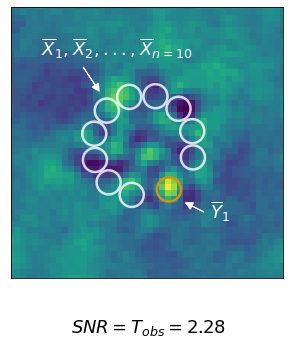

In [14]:
# Create the Layout with gridspec
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(1, 1)
ax_residual = fig.add_subplot(gs0[0])

# 1.) The Residual Plot
ax_residual.imshow(planet_residual)
ax_residual.scatter(np.array(noise_positions)[:,0],
                    np.array(noise_positions)[:,1],
                    marker="o",
                    facecolor="None",
                    edgecolor="white",
                    s=580, lw=2.5, alpha=0.8)

ax_residual.scatter(np.array([planet_position,])[:,0],
                    np.array([planet_position,])[:,1],
                    marker="o",
                    facecolor="None",
                    edgecolor=color_palette[1], 
                    s=580, lw=2.5,alpha=1)

ax_residual.set_xlim(15, 60)
ax_residual.set_ylim(15, 60)
ax_residual.axes.get_xaxis().set_ticks([])
_=ax_residual.axes.get_yaxis().set_ticks([])

# Write the Labels
ax_residual.text(20, 52, 
                 r"$\overline{X}_1, \overline{X}_2, ..., \overline{X}_{n=10}$", 
                 color="white", fontsize=18)

ax_residual.arrow(27, 50,
                  2, -3, color="white",
                  head_length=1.2,head_width=1.2)


ax_residual.text(48, 25, 
                 r"$\overline{Y}_1$", 
                 color="white", fontsize=18)

ax_residual.arrow(47, 26,
                  -2., 1., color="white",
                  head_length=1.2,head_width=1.2)

ax_residual.text(25, 6, 
                 r"$SNR = T_{obs} = " + "{:.2f}$".format(snr), 
                 color="black", fontsize=18)

fig.patch.set_facecolor('white')

plt.savefig("./01_01_observation.pdf",
            bbox_inches='tight')

### 2. Hypothesis & Assumptions

Create the second subplot which illustrates the two hypothesis: detection vs. no dectection.

In [15]:
# we use the same fuction to plot the H0 and H1
def plot_hypothesis(loc_noise, 
                    scale_noise,
                    loc_signal,
                    axis_in):
    
    # 2.1) Plot the hypothesis distribution
    x = np.linspace(stats.norm.ppf(0.00001, loc=loc_noise, scale=scale_noise),
                    stats.norm.ppf(0.99999, loc=loc_noise, scale=scale_noise), 1000)

    axis_in.plot(x, stats.norm.pdf(x, loc=loc_noise, scale=scale_noise)*0.9, 
                 label="Noise PDF",
                 color=color_palette[0], lw=3)

    axis_in.plot(x, stats.norm.pdf(x, loc=loc_signal, scale=scale_noise)*0.9 + 0.0004, 
                 label="Signal PDF",
                 color=color_palette[1], lw=3)

    axis_in.hlines(0, xmin=-200, xmax=200, color="black")

    # 2.2) Plot the observations
    axis_in.scatter(noise_flux,
                    np.zeros_like(noise_flux),
                    color = color_palette[0],
                    marker="x", lw=3, s=100,
                    label=r"$X_1, X_2, ..., X_n$")

    axis_in.axvline(np.mean(noise_flux),
                    ymin=-0.1, ymax=0.3, ls="-",
                    color=color_palette[0], lw=3)

    axis_in.text(np.mean(noise_flux), 0.0047, r"$\overline{\mathcal{X}}$",
                 ha="center", size=18)

    axis_in.scatter(planet_flux,
                  np.zeros_like(planet_flux), 
                  color = color_palette[1],
                  marker="x", lw=3, s=100, 
                   label=r"$Y_1$")

    axis_in.axvline(np.mean(planet_flux),
                  ymin=-0.1, ymax=0.3, ls="-",
                  color=color_palette[1], lw=3)

    axis_in.text(np.mean(planet_flux), 0.0047, r"$\overline{\mathcal{Y}}$",
               ha="center", size=18)

    # 2.3) Set label and limits
    axis_in.set_xlim(np.min(noise_flux)*2, planet_flux*1.8)
    axis_in.set_ylim(-0.002, 0.017)
    axis_in.axes.get_xaxis().set_ticklabels([])
    axis_in.axes.get_yaxis().set_ticklabels([])

Use the function from above to create the figure.

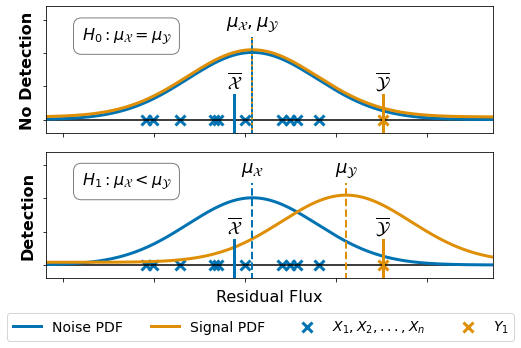

In [16]:
# Create the Layout with gridspec
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 1])
gs0.update(hspace=0.15, wspace=0.2)

ax_h0 = fig.add_subplot(gs0[0])
ax_h1 = fig.add_subplot(gs0[1])

# 1.) H0 Plot
loc_noise = np.mean(noise_flux) + 10
scale_noise = np.std(noise_flux) * 1.1
loc_signal = loc_noise

plot_hypothesis(loc_noise, scale_noise, loc_signal, ax_h0)
ax_h0.text(loc_signal, 0.014, r"$\mu_\mathcal{X}, \mu_\mathcal{Y}$",
           ha="center", size=18)
ax_h0.axvline(loc_noise,
              ymin=-0.1, ymax=0.75, ls="-",
              color=color_palette[0], lw=2)

ax_h0.axvline(loc_signal,
              ymin=-0.1, ymax=0.75, ls=":",
              color=color_palette[1], lw=2)

ax_h0.text(-65, 0.012, r"$H_0: \mu_\mathcal{X} = \mu_\mathcal{Y}$",
           ha="center", size=16,
           bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))

ax_h0.set_ylabel("No Detection", size=16, fontweight="bold")

# 2.) H1 Plot
loc_noise = np.mean(noise_flux) + 10
scale_noise = np.std(noise_flux) * 1.1
loc_signal = np.mean(planet_flux) - 20

plot_hypothesis(loc_noise, scale_noise, loc_signal, ax_h1)
ax_h1.text(loc_signal, 0.014, r"$\mu_\mathcal{Y}$",
           ha="center", size=18)

ax_h1.axvline(loc_signal,
              ymin=-0.1, ymax=0.75, ls="--",
              color=color_palette[1], lw=2)

ax_h1.text(loc_noise, 0.014, r"$\mu_\mathcal{X}$",
           ha="center", size=18)

ax_h1.axvline(loc_noise,
              ymin=-0.1, ymax=0.75, ls="--",
              color=color_palette[0], lw=2)

ax_h1.text(-65, 0.012, r"$H_1: \mu_\mathcal{X} < \mu_\mathcal{Y}$",
           ha="center", size=16,
           bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))

ax_h1.set_xlabel("Residual Flux", size=16)
ax_h1.set_ylabel("Detection", size=16, fontweight="bold")

# Add a legend
ax_h1.legend(ncol=4,
             fontsize=14, 
             loc='lower center',
             bbox_to_anchor=(0.48, -.55))

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./01_02_hypothesis.pdf",
            bbox_inches='tight')

### 3. Statistical Test & Conclusion

Create the last subplot which shows the t-distribution and the FPF for the given value of $T_{\text{obs}}$

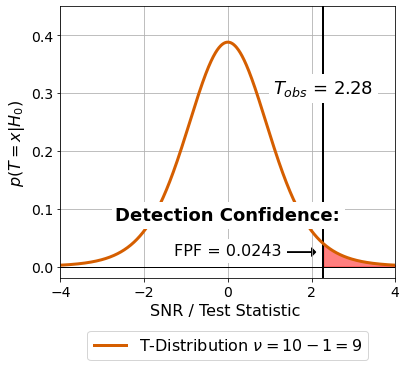

In [17]:
# Create the Layout with gridspec
fig = plt.figure(constrained_layout=False, figsize=(6, 5))
gs0 = fig.add_gridspec(1, 1)
axis_ttest = fig.add_subplot(gs0[0])

# collect all the data
m = 1 
n = len(noise_positions)
snr = test.test_2samp(planet_flux, noise_flux)[1]

x = np.linspace(stats.t.ppf(0.001, n+m-2),
                stats.t.ppf(0.999, n+m-2), 1000)

fill_x = np.arange(snr, 5, 0.01)
fill_y = stats.t.pdf(fill_x, n+m-2)

axis_ttest.axhline(0, color="black", lw=1)
axis_ttest.plot(x, stats.t.pdf(x, n+m-2),
                color=color_palette[2], 
                lw=3,
                label="T-Distribution " + r"$\nu = 10 - 1 = 9$")

axis_ttest.fill_between(fill_x, fill_y, color="red", alpha=0.5)
axis_ttest.vlines(snr, ymin=-0.1, ymax=1, 
                  color="black", lw=2)
axis_ttest.grid()

axis_ttest.text(snr, 0.3, r"$T_{obs}$" + " = {:.2f}".format(snr), 
                ha="center", size=18,
                bbox=dict(facecolor='white', edgecolor="white"))


axis_ttest.text(-0., 0.08, "Detection Confidence:", 
                ha="center", size=18,
                fontweight="bold",
                bbox=dict(facecolor='white', edgecolor="white")) 

axis_ttest.text(-0., 0.02, "FPF = {:.4f}".format(p_value), 
                ha="center", size=16,
                bbox=dict(facecolor='white', edgecolor="white"))

axis_ttest.arrow(1.2, 0.025, 0.8, 0., head_width=0.015, head_length=0.1, fc='k', ec='k')

axis_ttest.set_xlim(-4, 4)
axis_ttest.set_ylim(-0.02, 0.45)

axis_ttest.set_xlabel("SNR / Test Statistic ", fontsize=16)
axis_ttest.set_ylabel(r"$p(T = x | H_0)$", fontsize=16)

axis_ttest.tick_params(axis='both', which='major', labelsize=14)

axis_ttest.legend(ncol=1,
                  fontsize=16, 
                  loc='lower center',
                  bbox_to_anchor=(0.5, -.33))

#fig.patch.set_facecolor('white')
plt.savefig("./01_03_test.pdf",
            bbox_inches='tight')

We merge the plots using Illustrator